In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
from totaling.core import WorkflowTotaler

## Totaling scratch work
Let's try a minimal totaling step:
- manually pass output from Deconto (AIS) and Bamber (AIS & GIS) modules
- These were run in `../experiment_level/docker-compose-bamber-fair.yml` (`docker compose -f docker-compose-bamer-fair.yml up`)
- Outputs are written to `../experiment_level/data/output`
- We're only looking at **global** outputs (for now)
- Pass a list of the files you watn to be totaled


In [14]:
file0 = "/Users/emmamarshall/Desktop/facts_work/facts_v2/experiment_level/data/output/ais_gslr.nc"
file1 = "/Users/emmamarshall/Desktop/facts_work/facts_v2/experiment_level/data/output/output_ais_gslr.nc"
file2 = "/Users/emmamarshall/Desktop/facts_work/facts_v2/experiment_level/data/output/output_gis_gslr.nc"

files_ls = [file0, file1, file2]

Pass list of file paths and a name (doesn't do anything rn) to `WorkflowTotaler`.

In [15]:
totaler = WorkflowTotaler(name="bamber_deconto_global_outputs", paths_list=files_ls)

In [17]:
totaler.total_projections(scale="global")

AssertionError: No projections dataset found for scale 'global'. Please run get_projections first.

Once `WorkflowTotaler` created, call `get_projections(scale='global')` to read data cubes, add file dim and combine along file dim. 

In [18]:
totaler.get_projections(
    scale="global",
)

Then, call `WorkflowTotaler.total_projections()` method, this actually computes the sum and returns a `xr.DS`. 
- values along the `file` dim are just fillers
- the 'Description' `attr` on the totaled ds is incorrect, taken from the first module-output data cube

In [20]:
global_ds = totaler.total_projections(scale="global")
global_ds

<xarray.Dataset> Size: 74kB
Dimensions:                   (file: 3, samples: 500, years: 9, locations: 1)
Coordinates:
  * file                      (file) <U3 36B 'abc' 'abc' 'abc'
  * samples                   (samples) int32 2kB 0 1 2 3 4 ... 496 497 498 499
  * years                     (years) int32 36B 2020 2030 2040 ... 2090 2100
  * locations                 (locations) int32 4B -1
Data variables:
    sea_level_change          (file, samples, years, locations) float32 54kB dask.array<chunksize=(1, 500, 9, 1), meta=np.ndarray>
    lat                       (file, locations) float32 12B dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon                       (file, locations) float32 12B dask.array<chunksize=(1, 1), meta=np.ndarray>
    totaled_sea_level_change  (samples, years, locations) float32 18kB dask.array<chunksize=(500, 9, 1), meta=np.ndarray>
Attributes:
    description:  Global SLR contribution from AIS from the Deconto et al. 20...
    history:      Created Sat Nov 15 01:14:12 2025
    scenario:     rcp85
    baseyear:     2000

In [21]:
totaler.write_totaled_projections(
    outpath="/Users/emmamarshall/Desktop/scratch/totaled_test.nc", scale="global"
)

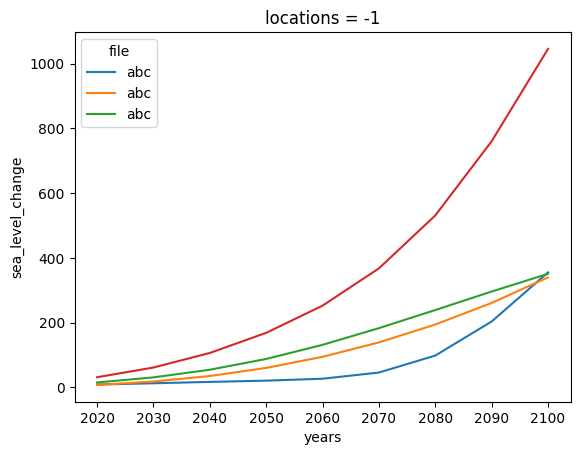

In [13]:
fig, ax = plt.subplots()
global_ds["sea_level_change"].squeeze().mean(dim="samples").plot(hue="file", ax=ax)
global_ds["sea_level_change"].sum(dim="file").mean(dim="samples").plot(
    ax=ax, label="total"
)